In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DRIVE_PATH = '/content/gdrive/My\ Drive/260final'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/260final'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [ ]:
%cd $SYM_PATH

if not os.path.exists("260final"):
    !git clone https://github.com/Dominicliu129/stat260final.git 260final
else:
    print("Already downloaded.")

%cd 260final

/content/gdrive/My Drive/260final
Cloning into '260final'...
fatal: could not read Username for 'https://github.com': No such device or address
[Errno 2] No such file or directory: '260final'
/content/gdrive/My Drive/260final


In [ ]:
!pwd

/content/gdrive/My Drive/260final


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

#Google Trends

In [ ]:
df = pd.read_csv('google_trend_ai.csv', skiprows=2)
df['Week'] = pd.to_datetime(df['Week'])

<Axes: xlabel='Week'>

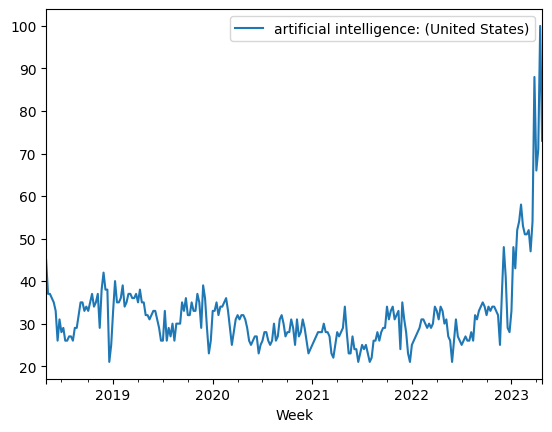

In [ ]:
df.plot(x='Week', y='artificial intelligence: (United States)')

In [ ]:
#df['numbers'] = range(len(df))
timeseries = df[["artificial intelligence: (United States)"]].values.astype('float32')

In [ ]:
lookback = 1
train_size = len(timeseries) - 5
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size+lookback], timeseries[train_size-lookback:]

In [ ]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([255, 1, 1]) torch.Size([255, 1, 1])
torch.Size([5, 1, 1]) torch.Size([5, 1, 1])


In [ ]:
class google_trends(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
model = google_trends()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 31.6097, test RMSE 80.2440
Epoch 100: train RMSE 5.1950, test RMSE 40.6923
Epoch 200: train RMSE 4.8810, test RMSE 31.4816
Epoch 300: train RMSE 4.2527, test RMSE 25.9463
Epoch 400: train RMSE 4.1521, test RMSE 23.8719


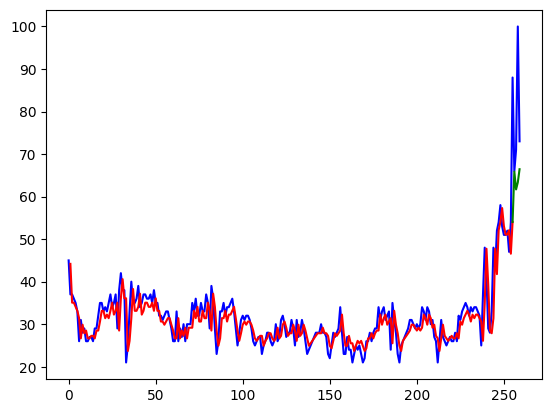

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size+lookback] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size:len(timeseries)+lookback] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [ ]:
print(test_plot[-10:])

[[      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [54.036434]
 [65.87571 ]
 [61.685757]
 [63.34208 ]
 [66.43682 ]]


## Rainfall

In [ ]:
df = pd.read_csv('CSVDataServlet.txt')

In [ ]:
df = df.loc[:, ['DATE TIME', 'VALUE']]

In [ ]:
df['DATE TIME'] = pd.to_datetime(df['DATE TIME'])

In [ ]:
df_grouped = df.groupby(df['DATE TIME'].dt.date)['VALUE'].agg('mean').reset_index()

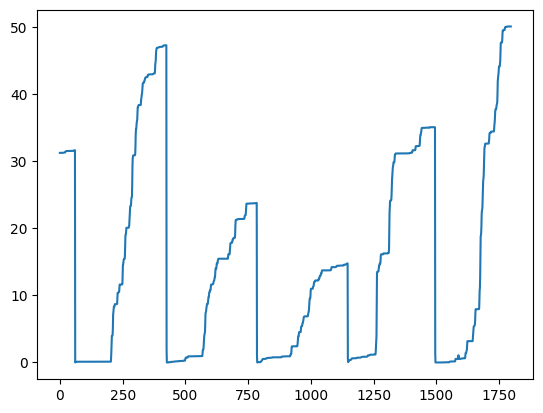

In [ ]:
timeseries = df_grouped[['VALUE']].values.astype('float32')
plt.plot(timeseries)
plt.show()

In [ ]:
np.savetxt("weather.csv", timeseries, delimiter=",")

In [ ]:
lookback = 4
train_size = len(timeseries) - 30
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size+lookback], timeseries[train_size-lookback:]

In [ ]:
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [ ]:
class rainfall(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
model = rainfall()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 12.9034, test RMSE 37.5058
Epoch 100: train RMSE 1.7324, test RMSE 2.1118
Epoch 200: train RMSE 1.6904, test RMSE 1.8348
Epoch 300: train RMSE 1.6843, test RMSE 1.7131
Epoch 400: train RMSE 1.6848, test RMSE 1.3951


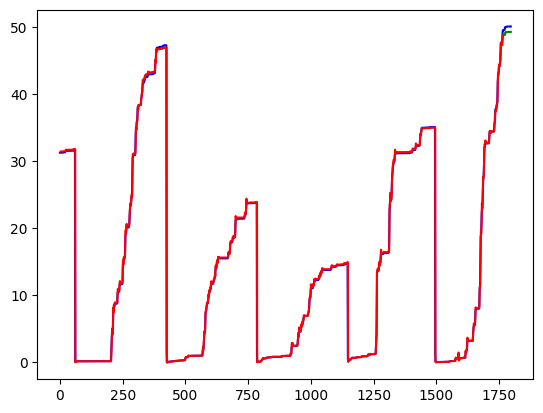

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size+lookback] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size:len(timeseries)+lookback] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [ ]:
print(test_plot[-31:])

[[      nan]
 [48.749294]
 [48.781956]
 [48.78084 ]
 [48.781006]
 [48.780388]
 [48.780228]
 [49.00718 ]
 [49.130306]
 [49.117638]
 [49.120495]
 [49.181763]
 [49.189568]
 [49.190735]
 [49.189686]
 [49.195114]
 [49.197758]
 [49.198715]
 [49.2241  ]
 [49.222073]
 [49.223145]
 [49.22249 ]
 [49.222466]
 [49.222466]
 [49.222466]
 [49.222466]
 [49.222466]
 [49.222466]
 [49.222466]
 [49.222466]
 [49.222466]]


##S&P500

In [ ]:
df = pd.read_csv('HistoricalData_1683073126605.csv')

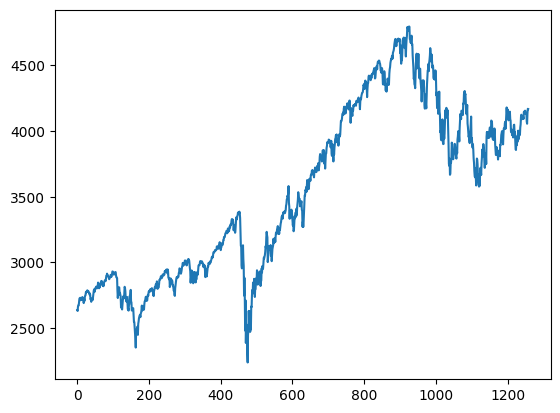

In [ ]:
timeseries = df[["Close/Last"]].values.astype('float32')[::-1]
plt.plot(timeseries)
plt.show()

In [ ]:
def minmax_scale(data, new_min=0, new_max=1):
    old_min = np.min(data)
    old_max = np.max(data)
    
    return (data - old_min) * (new_max - new_min) / (old_max - old_min) + new_min

In [ ]:
normalized_data = minmax_scale(timeseries)

In [ ]:
lookback = 1
train_size = len(normalized_data) - 20
test_size = len(normalized_data) - train_size
train, test = normalized_data[:train_size+lookback], normalized_data[train_size-lookback:]

In [ ]:
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

<ipython-input-14-a481a879330a>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(X), torch.tensor(y)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
class SNP(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True, dropout=0.5)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
model = SNP()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.1712, test RMSE 0.1169


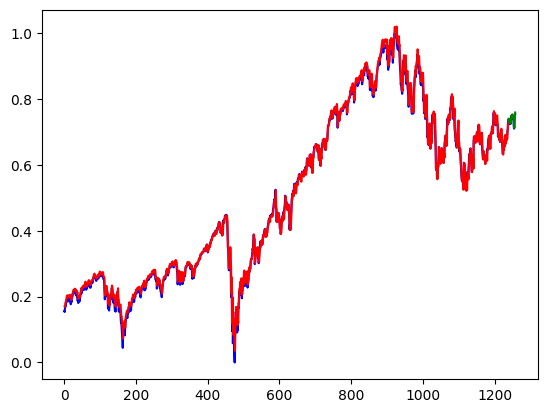

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size+lookback] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size:len(timeseries)+lookback] = model(X_test)[:, -1, :]
# plot
plt.plot(normalized_data, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [ ]:
print(test_plot[-21:])

[[       nan]
 [0.7349112 ]
 [0.74112886]
 [0.731351  ]
 [0.7271761 ]
 [0.73315746]
 [0.7348294 ]
 [0.7347599 ]
 [0.72781724]
 [0.7500199 ]
 [0.74650466]
 [0.7521101 ]
 [0.75356567]
 [0.75342214]
 [0.7432902 ]
 [0.7448174 ]
 [0.7462589 ]
 [0.7195238 ]
 [0.7131479 ]
 [0.7455668 ]
 [0.7595587 ]]


In [ ]:
def minmax_unscale(data, original_min, original_max, new_min=0, new_max=1):
    return (data - new_min) * (original_max - original_min) / (new_max - new_min) + original_min


In [ ]:
max_unnormalized = np.max(timeseries)
min_unnormalized = np.min(timeseries)

normalized_prediction = test_plot[-20:]

pred = minmax_unscale(normalized_prediction, min_unnormalized, max_unnormalized)

In [ ]:
gt = timeseries[-20:]

In [ ]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [ ]:
mean_squared_error(gt, pred)

883.4126

In [ ]:
pred

array([[4121.285 ],
       [4135.58  ],
       [4113.069 ],
       [4103.404 ],
       [4117.2407],
       [4121.0967],
       [4120.9365],
       [4104.89  ],
       [4155.899 ],
       [4147.883 ],
       [4160.6543],
       [4163.9614],
       [4163.6357],
       [4140.5327],
       [4144.027 ],
       [4147.3213],
       [4085.607 ],
       [4070.6982],
       [4145.74  ],
       [4177.537 ]], dtype=float32)